# Online DA: 
## CESM LME prior/LIM, HadCRUT5 observations

In [1]:
import sys
import numpy as np
import xarray as xr
import scipy.stats as spy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pickle 

In [2]:
sys.path.append("../")
import Online_DA_utils as oda

In [3]:
import importlib
importlib.reload(oda)

<module 'Online_DA_utils' from '../Online_DA_utils.py'>

In [4]:
t=0

# limname = 'cesm_lme_nh'
# modname = 'cesm_lme'
# obsname = 'cesm_lme'

limname = 'cesm_lme_Amon'
modname = 'cesm_lme_Amon'
#obsname = 'cesm_lme_Amon'
obsname = 'cmip6_mpi_hist_regridlme_Amon'

### Load L: 

In [5]:
LIM = oda.load_L(limname)
LIMd = LIM['LIMd']
LIMd.keys()

Loading: /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/master/LIMcast_cesm_lme_Amon_ntrain_850_1650_cesm_lme_Amon_validy_1651_1850_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20211202_sqrtWt.pkl


dict_keys(['vec', 'veci', 'val', 'lam_L', 'C_0', 'C_1', 'Gt', 'lam_L_adj', 'npos_eigenvalues', 'E3', 'W_all', 'standard_factor', 'E3_all', 'E_sic', 'var_dict', 'P_train', 'exp_setup', 'frac_neg_eigenvals'])

In [6]:
Projector_tas = LIMd['E3']['tas']

### Load pseudo observations: 

In [7]:
obsdir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/observations/'
obsfilename = 'TAS_pseudo_obs_'+obsname+'_1851_2005.pkl'

pseudo_obs_data = pickle.load(open(obsdir+obsfilename,"rb"))

In [8]:
pseudo_obs_full = pseudo_obs_data['observations']
obs_lat = pseudo_obs_data['obs_lat']
obs_lon = pseudo_obs_data['obs_lon']
obs_mask = pseudo_obs_data['H']

In [9]:
pseudo_obs_2d = np.reshape(pseudo_obs_full, (pseudo_obs_full.shape[0]*pseudo_obs_full.shape[1],
                           pseudo_obs_full.shape[2]))

In [10]:
tas_3d = pseudo_obs_data['X_var_3d'] 
tas_2d = np.reshape(tas_3d,(tas_3d.shape[0]*tas_3d.shape[1],tas_3d.shape[2]))

In [11]:
pseudo_obs_full.shape, pseudo_obs_2d.shape

((9, 36, 1860), (324, 1860))

## Load initial conditions in eof space: 

In [12]:
priordir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/priors/'
priorname = 'Xb_initial_'+modname+'_300ndof_1651_1850.pkl'
#validname = 'Xb_initial_'+modname+'_300ndof_1851_2005.pkl'
trainname = 'Xb_initial_'+modname+'_300ndof_850_1650.pkl'

Xb_initial_data = pickle.load(open(priordir+priorname,"rb"))
Xb_initial_allt = Xb_initial_data['Xb_initial']

In [13]:
Xb_train_data = pickle.load(open(priordir+trainname,"rb"))
Xb_train_allt = Xb_train_data['Xb_initial']

In [14]:
ndof_total = 0
limvars = ['tas','psl','zg','tos','sit','sic']
for var in limvars: 
    ndof_total = ndof_total+LIMd['var_dict'][var]['var_ndof']

In [15]:
Pb_initial = LIMd['C_0']


In [33]:
Pb_initial.min(), Pb_initial.max()

(-0.13204806346380715, 0.29785207823793775)

In [19]:
Pb_initial[0:50,-50:].min(), Pb_initial[0:50,-50:].max()

(-0.01869139046468231, 0.040302207672658574)

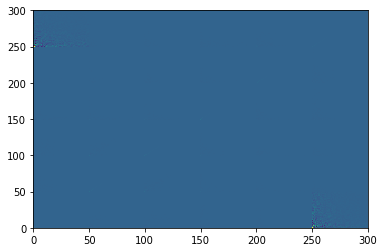

In [25]:
plt.pcolormesh(Pb_initial*inflator)

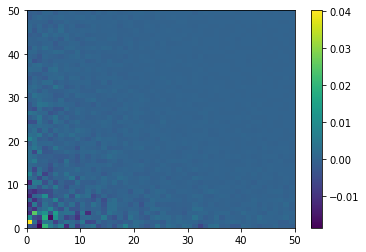

In [31]:
plt.pcolormesh(Pb_initial[0:50,-50:])#-Pb_initial[-50:,0:50])
plt.colorbar()

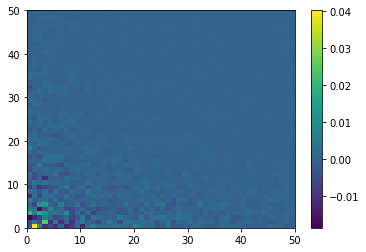

In [20]:
plt.pcolormesh(Pb_initial[-50:,0:50])
plt.colorbar()

In [24]:
inflator = np.ones_like(Pb_initial)
#inflator[250:,250:] = inflator[250:,250:]*2
inflator[0:50,-50:] = inflator[0:50,-50:]*100
inflator[-50:,0:50] = inflator[-50:,0:50]*100

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 2., 2., 2.],
       [1., 1., 1., ..., 2., 2., 2.],
       [1., 1., 1., ..., 2., 2., 2.]])

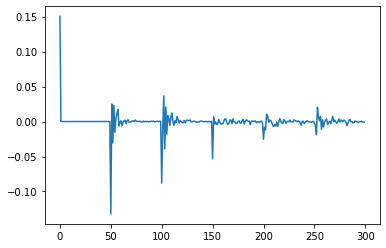

In [18]:
plt.plot(LIMd['C_0'][0,:])

In [19]:
Xb_initial_allt.shape

(300, 2400)

### Build H:
H should be a matrix of size (nobs, nlalo) filled with zeros and ones. One one per column at the ob location. 

In [20]:
H_cap, nobs, ndof = oda.build_H_time(obs_mask[:,:,0])

In [21]:
H = np.zeros((nobs,ndof_total))
H[:,0:6912] = H_cap

In [22]:
neofs = 300

In [23]:
E3_all = np.zeros((ndof_total,neofs))
ntrunc = 50

for v,var in enumerate(limvars): 
    E3_all[LIMd['var_dict'][var]['var_inds'],
           int(v*ntrunc):int((v+1)*ntrunc)] = LIMd['E3'][var]/np.sqrt(LIMd['standard_factor'][var])

In [24]:
U = E3_all

H_eof = np.matmul(H,U)

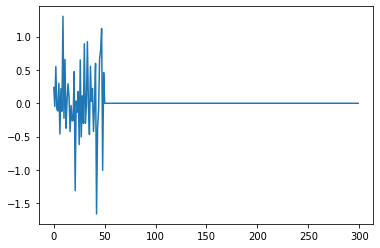

In [25]:
plt.plot(H_eof[1,:])

### Build R: 

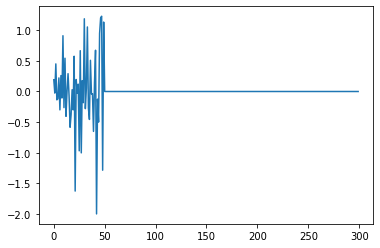

In [26]:
plt.plot(H_eof[0,:])

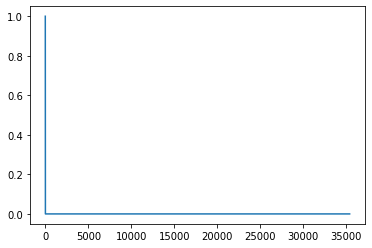

In [27]:
plt.plot(H[0,:])

In [36]:
tas_2d.shape, Xb_train_allt.shape

((6912, 1860), (300, 9612))

In [37]:
Hx = np.matmul(H_eof,Xb_train_allt[:,-1860:])

In [38]:
Hx_cap = np.matmul(H_cap,tas_2d)

In [39]:
Hx.shape, Hx_cap.shape, 100*100

((324, 1860), (324, 1860), 10000)

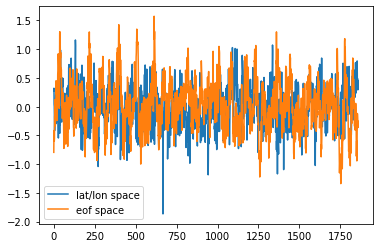

In [40]:
plt.plot(Hx_cap[0,:], label='lat/lon space')
plt.plot(Hx[0,:], label='eof space')
plt.legend()

In [41]:
epsilon = Hx_cap - Hx

In [42]:
R = np.matmul(epsilon,epsilon.T)/(epsilon.shape[0]-1)

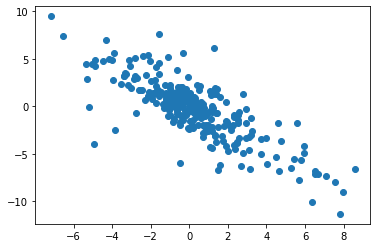

In [43]:
plt.scatter(Hx[:,0],epsilon[:,0])

In [44]:
epsilon.shape

(324, 1860)

In [45]:
slope, intercept, r, p, se = spy.linregress(Hx[:,0],epsilon[:,0])

In [46]:
slope, intercept

(-0.984102650778857, -0.07014144186286914)

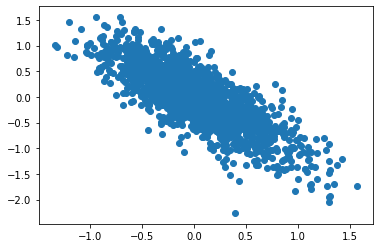

In [47]:
x = np.arange(-300000,300000,1)

#plt.plot(x,slope*x+intercept, color='r')

plt.scatter(Hx[0,:],epsilon[0,:])

## Initial timestep - Kalman Filtering: 

In [48]:
t = 0

In [75]:
Xb = np.nan_to_num(Xb_initial_allt[:,0])
Y = pseudo_obs_2d[:,t]

Pb = Pb_initial*inflator
R_hack = R
H_final = H_eof

Xa, K, K_den, diff = oda.solver_KF_update(Xb, Pb, Y, R_hack, H_final)

In [76]:
# plt.plot(Pb[0,:], label='Pb')
# plt.plot(R_hack[0,:], label='R')

# plt.legend(fontsize = 12)

In [77]:
R_hack.max(), R_hack.min(), 

(175.71887242964044, -51.80135652966944)

In [78]:
Pb.max(), Pb.min()

(0.29785207823793775, -0.13204806346380715)

In [54]:
Pa = oda.solver_KF_cov(K,H_final,Pb)

In [55]:
mse_xb = np.nanmean(diff**2)
mse_xa = np.nanmean((Y - np.matmul(H_eof,Xa))**2)
print('Prior MSE     = '+str(mse_xb))
print('Posterior MSE = '+str(mse_xa))

Prior MSE     = 11.26951966297491
Posterior MSE = 4.514810049418007


In [56]:
diffcov = np.dot(diff[:,np.newaxis],diff[:,np.newaxis].T)/diff.shape[0]
ratio = (np.diagonal(diffcov)/np.diagonal(K_den))
print('Median Ratio = '+str(np.median(ratio)))
print('Mean Ratio = '+str(np.mean(ratio)))

Median Ratio = 0.36293105331043596
Mean Ratio = 0.9099625828096881


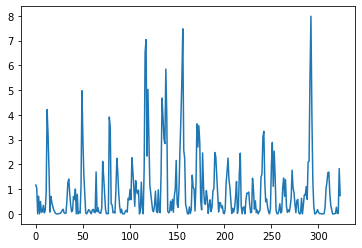

In [57]:
plt.plot(np.diagonal(diffcov)/np.diagonal(K_den))

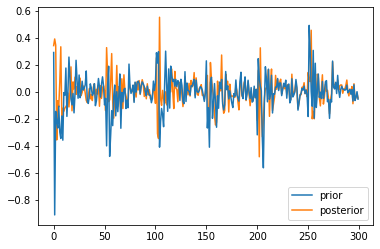

In [59]:
plt.plot(Xb, label='prior',zorder=1)
plt.plot(Xa, label = 'posterior',zorder=0)
plt.legend()

## Forecast Step: 

In [60]:
LIM_Xfcast = oda.LIM_forecast(LIMd,Xa,Pa,1,adjust=False)

Adjust is False...
lag= 1


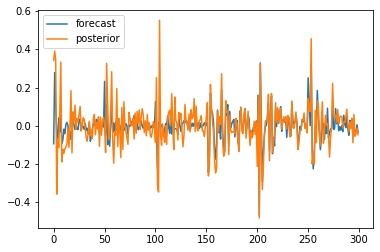

In [61]:
plt.plot(LIM_Xfcast['x_forecast'], label='forecast')
plt.plot(Xa, label = 'posterior')
plt.legend()

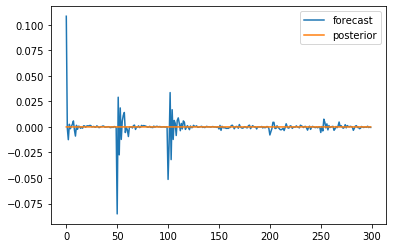

In [62]:
plt.plot(LIM_Xfcast['cov_forecast'][0,:], label='forecast')
plt.plot(Pa[0,:], label = 'posterior')
plt.legend()

In [63]:
t=1

In [64]:
Xb_initial = LIM_Xfcast['x_forecast']
Pb = LIM_Xfcast['cov_forecast']*1e-2

Y = pseudo_obs_2d[:,t]

In [65]:
Xa, K, K_den, diff = oda.solver_KF_update(Xb_initial, Pb, Y, R_hack, H_final)

In [66]:
Pa = oda.solver_KF_cov(K,H_final,Pb)

In [67]:
mse_xb = np.nanmean(diff**2)
mse_xa = np.nanmean((Y - np.matmul(H_eof/100,Xa))**2)
print('Prior MSE     = '+str(mse_xb))
print('Posterior MSE = '+str(mse_xa))

Prior MSE     = 6.7912500255647865
Posterior MSE = 5.122034921624615


In [68]:
diffcov = np.dot(diff[:,np.newaxis],diff[:,np.newaxis].T)/diff.shape[0]
ratio = (np.diagonal(diffcov)/np.diagonal(K_den))
print('Median Ratio = '+str(np.median(ratio)))
print('Mean Ratio = '+str(np.mean(ratio)))

Median Ratio = 0.48441714379887313
Mean Ratio = 1.4079204435800412
